In [123]:
import util
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sys

# Two batches 

In [124]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

X = mnist.train._images.reshape(55000, 28, 28, 1)
Y = mnist.train._labels
index = np.arange(55000)
np.random.shuffle(index)

#batch1 = util.BatchFeeder(X[index[:27000]], Y[index[:27000]], 64)
#batch2 = util.BatchFeeder(X[index[27000:54000]]+np.ones((27000,28,28,1))/2.0, Y[index[27000:54000]], 64)

batch1 = util.BatchFeeder(X[index[:128*210]], np.zeros((128*210, 1)), 128)
batch2 = util.BatchFeeder(X[index[128*210:128*210*2]]+np.ones((128*210,28,28,1))/2.0, np.ones((128*210, 1)), 128)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


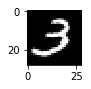

In [125]:
x = batch1.next()[0][0,:,:,0]
plt.figure(figsize=(1,1))
plt.imshow(x, cmap="gray", vmin=0, vmax=1)
plt.show()

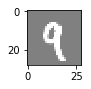

In [126]:
x = batch2.next()[0][0,:,:,0]
plt.figure(figsize=(1,1))
plt.imshow(x, cmap="gray", vmin=0, vmax=1)
plt.show()

# Model with 2 layer CNN

In [131]:
class DeepBatch:
    def __init__(self):
        # Reset all existing tensors
        tf.reset_default_graph()
        
        # Parameters
        self.built = False
        self.batchsize = 128
        self._lambda = 10
        self.sesh = tf.Session()
        self.e = 0
        
        # Building the graph
        self.ops = self.build()
        self.sesh.run(tf.global_variables_initializer())
    
    def build(self):
        if self.built:
            return -1
        else:
            self.built = True
             
        # Placeholders for input
        x1 = tf.placeholder(tf.float32, shape=[self.batchsize, 28, 28, 1], name="x1")
        x2 = tf.placeholder(tf.float32, shape=[self.batchsize, 28, 28, 1], name="x2")
        
        # Network
        out1 = self.discriminator(x1, reuse=None)
        out2 = self.discriminator(x2, reuse=True)
            
        # Define cost as the sum of KL and reconstrunction ross with BinaryXent.
        with tf.name_scope("cost"):
            
            ########### Loss calculations ############
            alpha = tf.random_uniform(shape=[self.batchsize,1] ,minval =0., maxval=1.) # here we calculate the gradient penalty 
            difference = x2 - x1
            inter = []
            for i in range(self.batchsize): 
                inter.append(difference[i] *alpha[i])
            inter = tf.stack(inter)
            
            interpolates = x1 + inter
            gradients = tf.gradients(self.discriminator(interpolates, reuse= True),[interpolates])[0]
            slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
            gradient_penalty = tf.reduce_mean((slopes-1.)**2.)
        
            d_loss = -tf.reduce_mean(out1) + tf.reduce_mean(out2) + 10.*gradient_penalty
            g_loss = -tf.reduce_mean(out2)
    
        # Optimization
        with tf.name_scope("Adam_optimizer"):
            train = tf.train.AdamOptimizer( learning_rate = 1e-4, beta1=0.5, beta2=0.9).minimize(d_loss)
            gs = tf.gradients(ys=g_loss, xs=x2)[0]
            print gs
            
        return dict(
            x1 = x1,  
            x2 = x2,  
            train = train,
            d_loss = d_loss,
            g_loss = g_loss,
            gs = gs
        )
    
    def discriminator(self, _input, reuse=None):
        with tf.variable_scope("discriminator", reuse=reuse):
            # Network
            layer1 = tf.contrib.layers.conv2d(_input, 64, kernel_size=(5,5), activation_fn=tf.nn.relu)
            layer1 = tf.contrib.layers.max_pool2d(layer1, kernel_size=(3,3), stride=(2,2))

            layer2 = tf.contrib.layers.conv2d(layer1, 128, kernel_size=(5,5), activation_fn=tf.nn.relu)
            layer2 = tf.contrib.layers.max_pool2d(layer2, kernel_size=(3,3), stride=(2,2))

            dense = tf.contrib.layers.flatten(layer2)
            out = tf.contrib.layers.fully_connected(dense, 1, activation_fn=tf.identity)
        return out
    
    # Closing session
    def close(self):
        self.sesh.close()
    
    # training procedure.
    def train(self, X1, X2, epochs):
        
        # Defining the number of batches per epoch
        batch_num = int(np.ceil(X1.n*1.0/X1.batch_size))
        
        e = 0
        start_e = self.e
        ret = []
        while e < epochs:
            
            if e%5 == 0:
                temp = []
            
            for i in range(batch_num):
                #Training happens here.
                batch1 = X1.next()
                batch2 = X2.next()
                feed_dict = {self.ops["x1"]: batch1[0],
                             self.ops["x2"]: batch2[0]}
                ops_to_run = [self.ops["d_loss"],
                              self.ops["g_loss"],
                              self.ops["gs"],
                              self.ops["train"]]
                cost, _, gs, _= self.sesh.run(ops_to_run, feed_dict)
                
                sys.stdout.write("\rEpoch: [%2d/%2d] Batch: [%2d/%2d] loss: %.2f"%(self.e, start_e+epochs, i, batch_num, -1*cost))

                if e%5 == 0:
                    temp.append(batch2[0]-0.01*gs)
                
            if e%5 == 0:
                ret.append(X)
                temp = np.concatenate(temp, axis=0)
                X2 = util.BatchFeeder(temp, np.ones((128*210, 1)), 128)
            self.e+=1
            e+= 1
        return gs, np.concatenate([batch1[0], batch2[0]], axis=0), ret
            
    def save(self, folder):
        saver = tf.train.Saver(tf.all_variables())
        os.system("mkdir "+folder)
        saver.save(self.sesh, folder+"/model.ckpt")
        
    def load(self, folder):
        saver = tf.train.Saver(tf.all_variables())
        saver.restore(self.sesh, folder+"/model.ckpt")

In [132]:
model = DeepBatch()

Tensor("Adam_optimizer/gradients_1/discriminator_1/Conv/Conv2D_grad/Conv2DBackpropInput:0", shape=(128, 28, 28, 1), dtype=float32)


In [133]:
out = model.train(batch1, batch2, 20)

Epoch: [19/20] Batch: [209/210] loss: 209.56

ind: 110


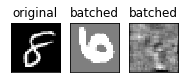

In [134]:
index = np.random.randint(128)
print "ind:", index

plt.figure(figsize=(3,1))
plt.subplot(131)
plt.imshow(out[1][index, :, :, 0], cmap="gray", vmin=0, vmax=1)
plt.yticks([],[])
plt.xticks([],[])
plt.title("original")
plt.subplot(132)
plt.imshow(out[1][index+128, :, :, 0], cmap="gray", vmin=0, vmax=1)
plt.yticks([],[])
plt.xticks([],[])
plt.title("batched")
plt.subplot(133)
plt.imshow(out[0][index, :, :, 0], cmap="gray")
plt.yticks([],[])
plt.xticks([],[])
plt.title("batched")
plt.show()